# Neural Network for Predicting Points Inside the Unit Circle 🎯


In this notebook, we will build a neural network that tries to predict whether a point in two-dimensional space $\mathbb{R}^2$ is inside the unit circle or not. The unit circle is a circle with a radius of 1 and centered at the origin (0,0).

The problem of determining whether a point is inside the unit circle or not is a classic example of a binary classification problem, where the neural network needs to learn to classify data into one of two classes: inside the unit circle (class 1) or outside the unit circle (class 0).

To solve this problem, we will create a simple neural network using the Keras API in TensorFlow. We will first generate a dataset of points in R2 and their corresponding labels (0 or 1) based on whether they are inside or outside the unit circle. Then, we will train the neural network on this dataset and evaluate its performance on a separate test set.

By the end of this notebook, you will have learned how to build a simple neural network for binary classification tasks, and how to apply it to a practical problem. So, let's get started!

In [1]:
from os import getcwd
from os.path import join, dirname
import sys
from src import model, plot, utils
import math
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

PATH_REPO = (getcwd())
PATH_MODELS = join(PATH_REPO, 'models') 

## Hyperparameters

In [2]:
RADIUS = 1 #math.sqrt(2/math.pi)
train_size = 10000
test_size = 1000

# 1. Generate Data class

generates a synthetic dataset consisting of 2D vectors and binary labels indicating whether each vector is inside or outside a 2D sphere. The dataset has n samples and a given radius.

The *generate_2d_uniform_vectors(n)* function generates n 2D vectors with uniformly distributed components in the range [-1, 1]. It returns a torch.Tensor object of size (n, 2).

The *is_in_2d_sphere(x, radius, center)* function takes as input a set of 2D vectors x and a radius radius, and determines whether each vector is inside or outside a 2D sphere centered at center (defaulted to [0,0]). It returns a torch.Tensor object of size (n, 2), where each row is a one-hot vector encoding the binary label for each input vector.

Finally, the *GenerateUnitSphere2dDataset* class initializes n vectors using *generate_2d_uniform_vectors(n)*, and labels them using *is_in_2d_sphere(coordinates, radius)*. It implements the \__len__ and \__getitem__ methods required to use this class as a PyTorch dataset, which will return a tuple containing the 2D vector and its corresponding binary label at a given index.

In [3]:
def generate_2d_uniform_vectors(n) -> torch.Tensor:
    return 4*(torch.rand(n,2) - 0.5)

def is_in_2d_sphere(x:torch.Tensor, radius:float, center=torch.Tensor([0,0])) -> torch.Tensor:
    y = torch.sum((x - center)**2, 1)
    y[y<radius**2] = 0
    y[y>radius**2] = 1
    return torch.nn.functional.one_hot(y.long(), num_classes=2)

class GenerateUnitSphere2dDataset(Dataset):
    def __init__(self, n: int, radius: float):
        self.n = n
        self.coordinates = generate_2d_uniform_vectors(self.n)
        self.labels = is_in_2d_sphere(self.coordinates, radius)

    def __len__(self):
        return len(self.labels)
		
    def __getitem__(self, idx):
	    return self.coordinates[idx], self.labels[idx]


In [4]:
train_set = GenerateUnitSphere2dDataset(n=train_size, radius=RADIUS)
test_set = GenerateUnitSphere2dDataset(n=test_size, radius=RADIUS)

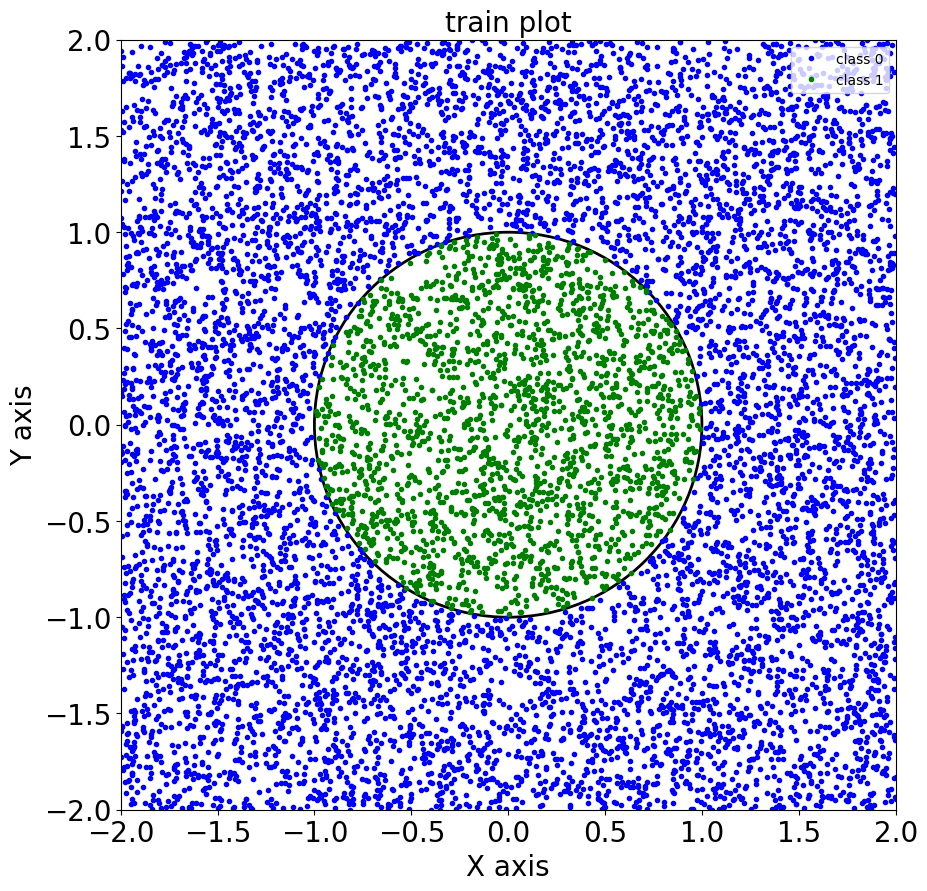

In [5]:
plot.plot_circle_with_labels (train_set.coordinates, train_set.labels, 'train plot')

## 2. Model

* The neural network is defined as a class called ShallowNetwork which inherits from the PyTorch nn.Module class. 
* The __init__ function initializes the network layers by creating two linear layers, self.h1 and self.fc, with 128 and 2 output units, respectively. 
* The forward function defines the forward pass of the network, applying a ReLU activation function on the hidden layer self.h1 and a sigmoid activation function on the output layer self.fc. 
* Finally, there is a method called predict that takes in an input tensor x and returns the predicted class label by applying the forward function and selecting the class with the maximum probability.

In [6]:
class SphereNeuralNetwork(nn.Module):
    def __init__(self):
        super(SphereNeuralNetwork, self).__init__()

        self.h1 = nn.Linear(2, 128)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):

        out = F.relu(self.h1(x))

        out = F.sigmoid(self.fc(out))

        return out
    
    def predict(self, x):
        
        out = self.forward(x)
        _,pred = torch.max(out, 1)
        return pred 

model_shallow = SphereNeuralNetwork()

## 3. Train

Here are some reasons why we use DataLoaders in PyTorch:

1. Batching: DataLoaders provide an easy way to batch data, which is useful because training on larger batch sizes can improve model performance, while smaller batch sizes can improve convergence.

2. Shuffling: DataLoaders can shuffle the data in each epoch to reduce bias and avoid overfitting.

3. Loading: DataLoaders can load data from various sources, such as CSV files, image directories, and databases.

4. Parallelizing: DataLoaders can automatically parallelize data loading and pre-processing across multiple CPUs, which can significantly speed up the training process.

5. Pre-processing: DataLoaders can also be used to apply pre-processing transforms to the data, such as normalization, scaling, and data augmentation.

Overall, DataLoaders provide a convenient and efficient way to manage data in PyTorch, making it easier to train and evaluate machine learning models.

In [7]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True)

This code defines a function train_one_epoch that trains a PyTorch model for one epoch using a specified train_loader data loader and optimizer optimizer.

In [8]:
def train_one_epoch(model, train_loader, optimizer):

    running_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        output = model(inputs).squeeze()
        target = labels.to(torch.float32)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss

Let's train the Network, we will output the plots for the loss and accuracy.

In [9]:
EPOCHS = 200
optimizer = torch.optim.SGD(model_shallow.parameters(), lr=0.01)

accs = []
losses = []
for epoch in range(EPOCHS):
    losses.append(train_one_epoch(model_shallow, train_loader, optimizer))
    accs.append((utils.evaluate(model_shallow, train_loader)/len(train_loader)))
    #print(model_shallow.predict(train_set.coordinates))


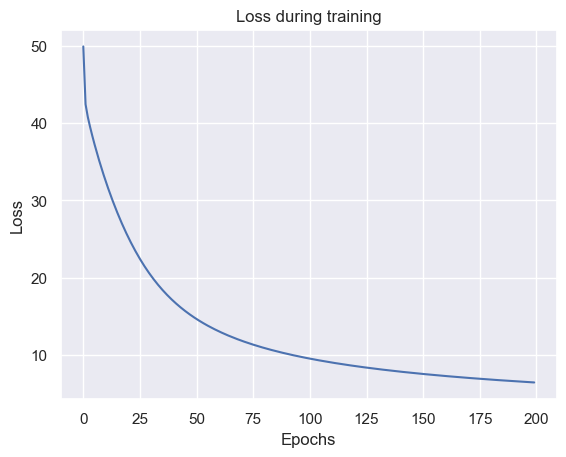

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np


plt.plot(np.arange(200), losses)
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

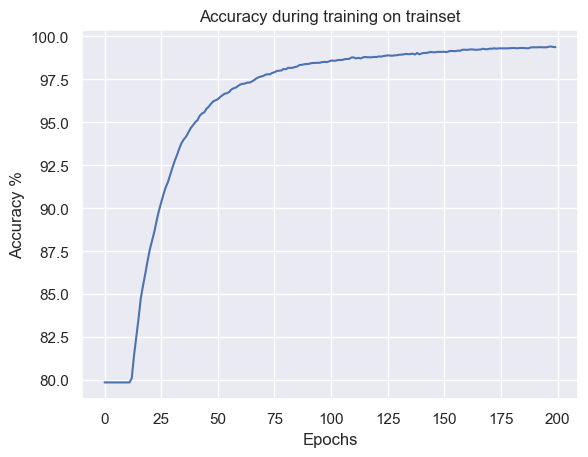

In [16]:
plt.plot(np.arange(200), accs)
plt.title('Accuracy during training on trainset')
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.show()

## 4. Evaluation Test Set

In [14]:
utils.evaluate(model_shallow, test_loader)/len(test_loader)

98.4

## 5. Save Model

In [23]:
torch.save(model_shallow.state_dict(), join(PATH_MODELS, 'ffn_sphere.pt'))